In [17]:
# Python Standard Libraries
import os

# Python Scientific Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Project Libraries
import lib.exp4 as exp4
import lib.reconstruction.errors as errs
import lib.reconstruction.features as ftrs
import lib.reconstruction.neighbors as nbrs

import lib.utility_functions as uf
import lib.util.datatype_utilities as dtutils

# Config
sns.set_style('white')
sns.set_context('paper')

pd.set_option('display.max_columns', 40)

% matplotlib inline

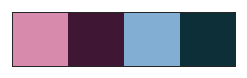

In [18]:
colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)
sns.palplot(colors)

In [19]:
colors = dict(zip(['real', 'fake', 'trained', 'untrained'], colors))

In [20]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)
tidy['Num Dif'] = tidy['Num Pieces (final)'] - tidy['Num Pieces']

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [21]:
mean_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces']
)

mean_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

std_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces'],
    aggfunc=np.std
)

std_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

In [22]:
tidy['x'] = tidy['Num Pieces']
tidy['y'] = tidy['Type II Errors']
tidy['y2'] = tidy['Type II Errors'] / tidy['Num Pieces']

In [23]:
c_filter = mean_piv['Condition'] == 'Trained'

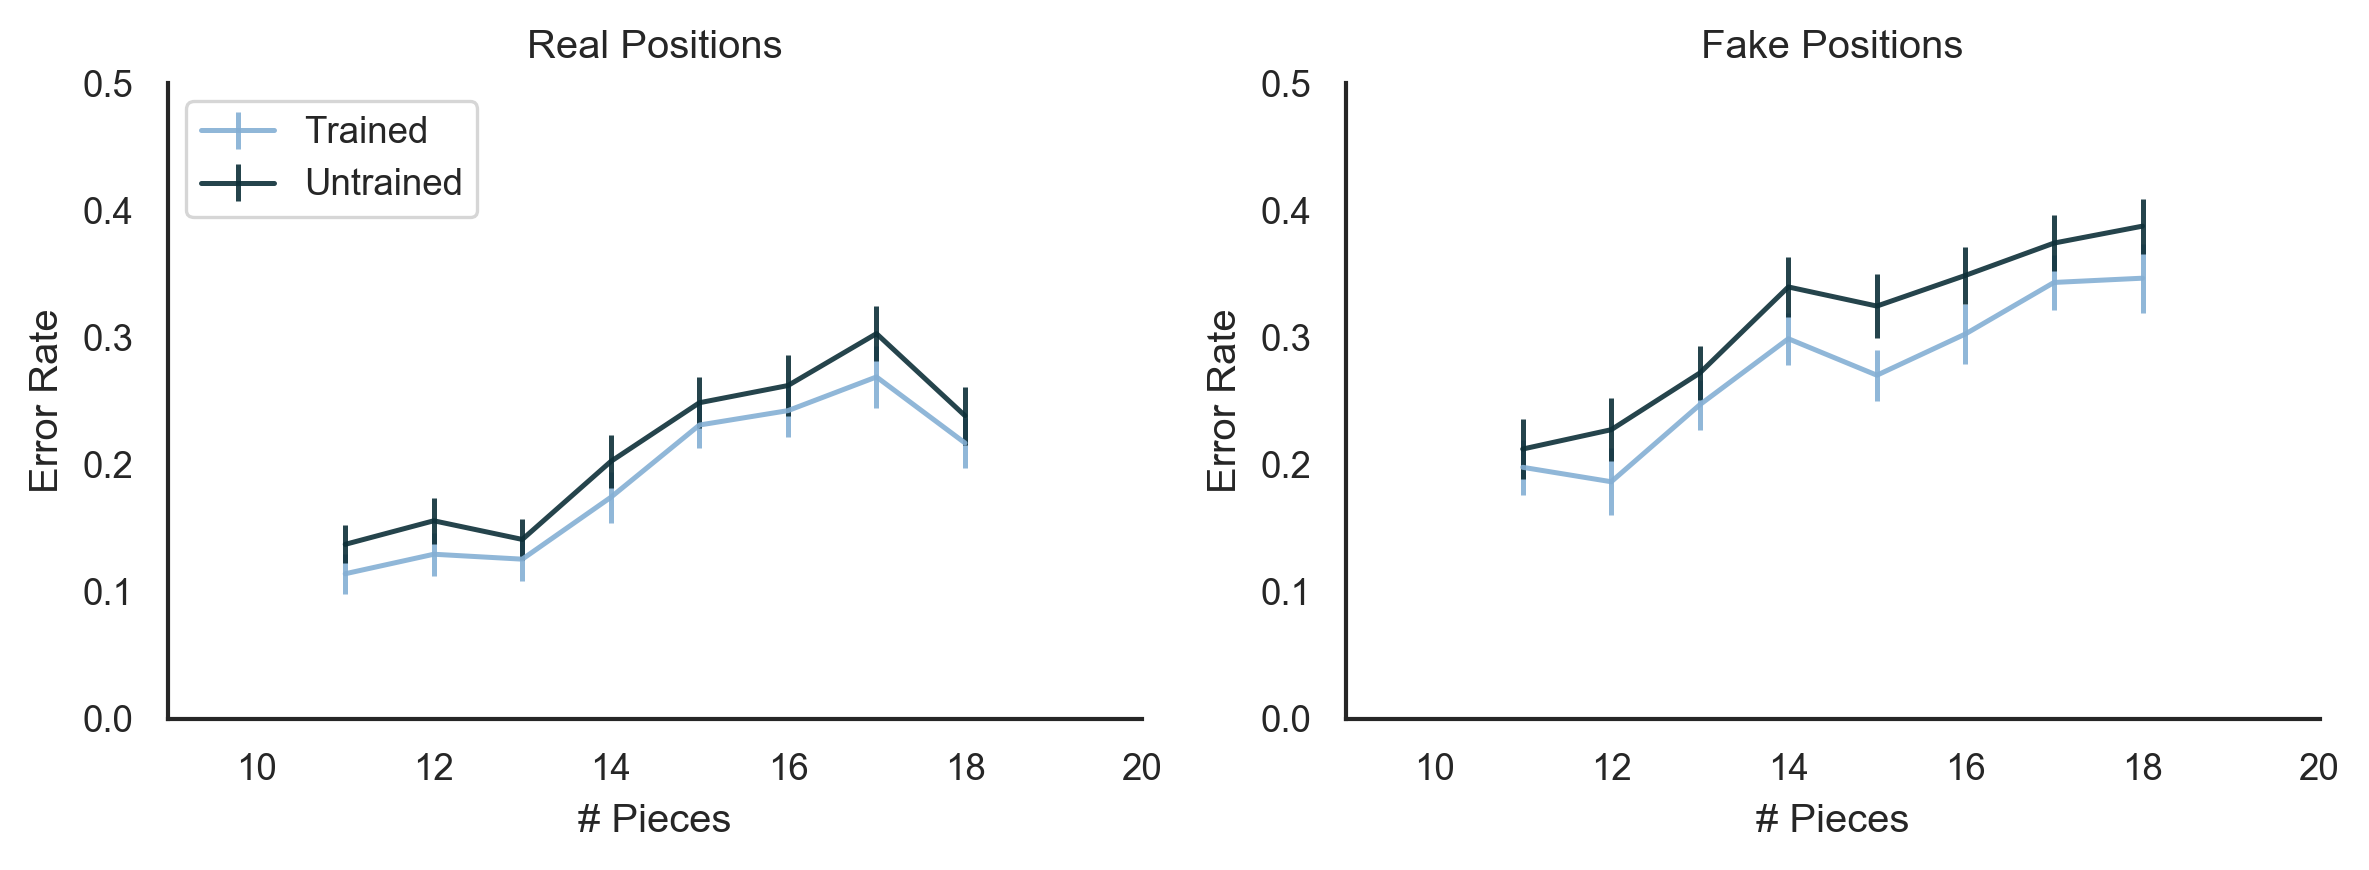

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True


def errbar_plot(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='y2', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


## Real

ax = axes[0]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors['trained'], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & tp_filter],
    ax=ax, color=colors['untrained'], alpha=.9, label='Untrained'
)


## Fake

ax = axes[1]

#### Trained

errbar_plot(
    tidy.loc[tc_filter & ~tp_filter], 
    ax=ax, color=colors['trained'], alpha=.9, label='Trained'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & ~tp_filter],
    ax=ax, color=colors['untrained'], alpha=.9, label='Untrained'
)

## Make it fancy

# axes[0].plot(np.arange(20), color='grey')
# axes[1].plot(np.arange(20), color='grey')

axes[0].legend(loc=2)

plt.setp(
    axes, 
    ylabel='Error Rate', xlabel='# Pieces', 
    xlim=[9, 20], 
    ylim=[0, .5]
#     ylim=[0, 12],
#     xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()
plt.tight_layout()

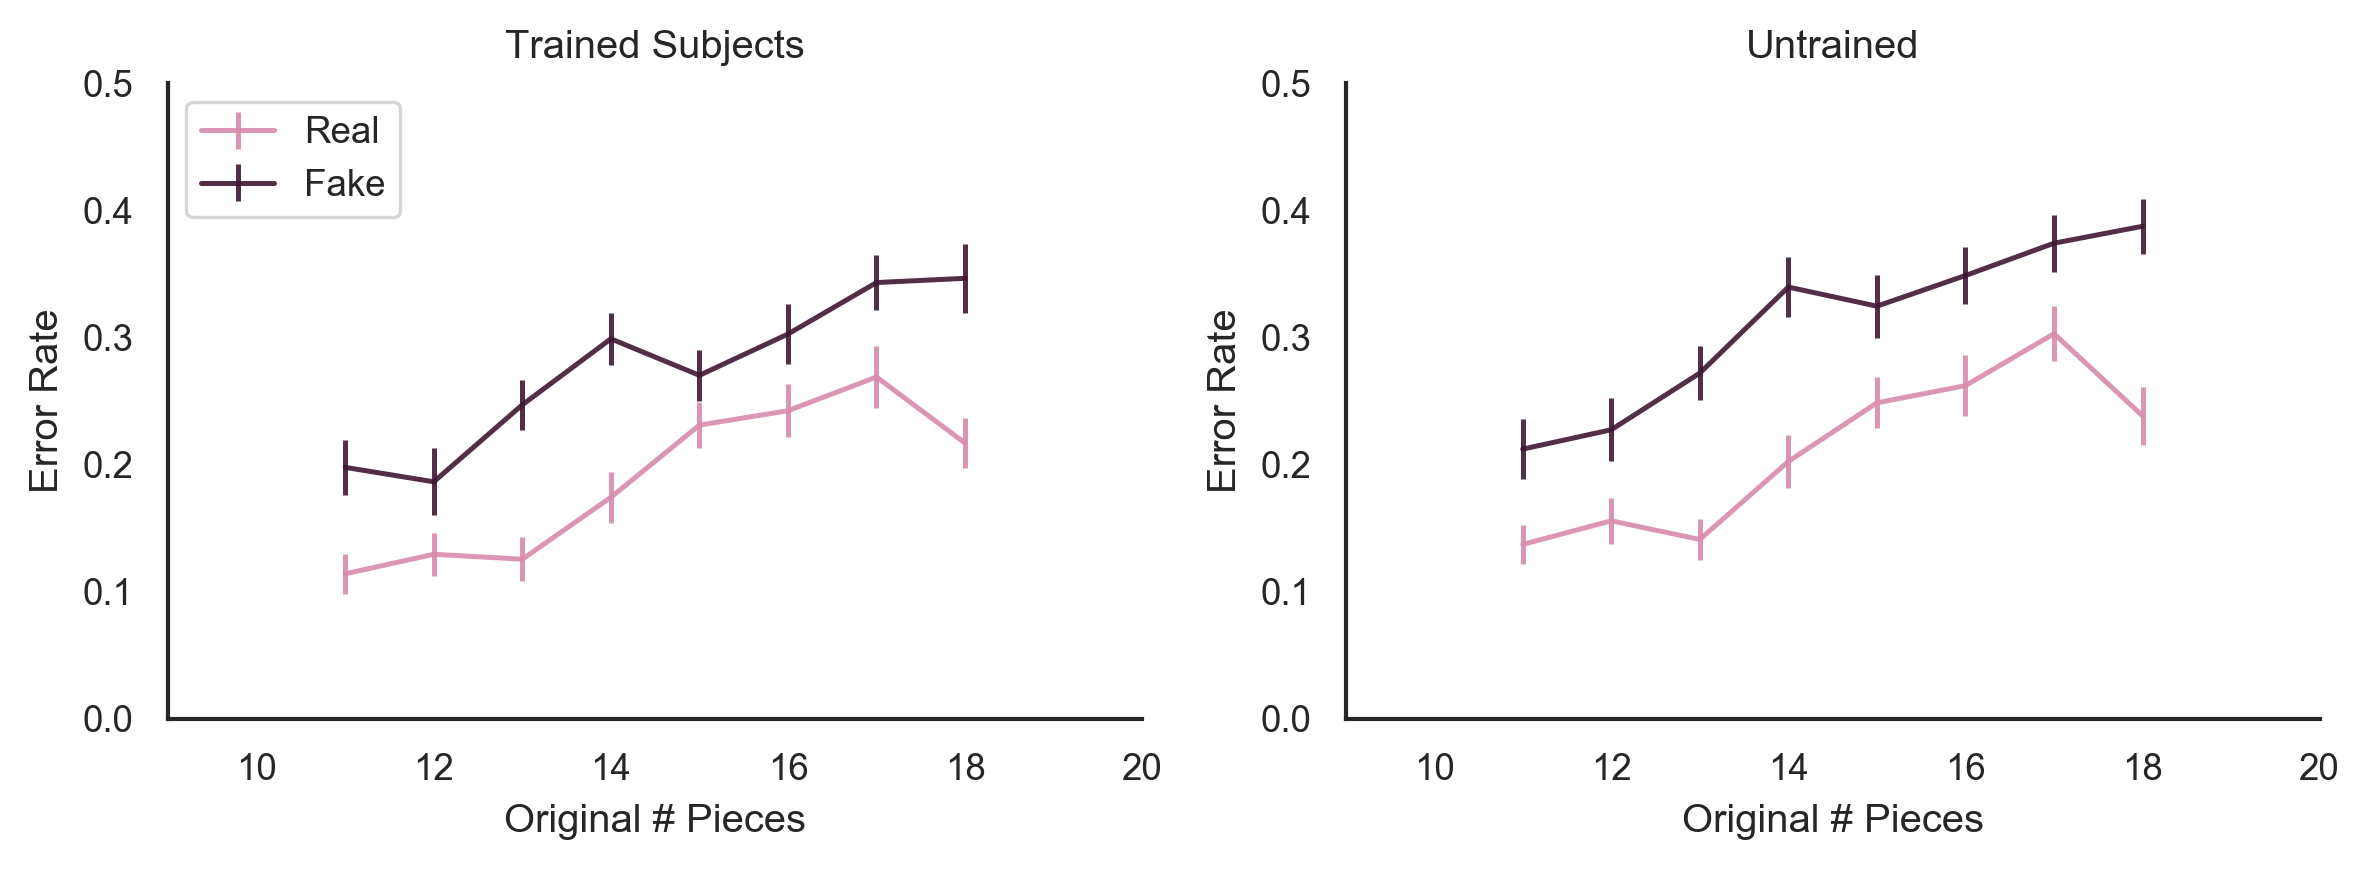

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True


def errbar_plot(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='y2', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None


## Trained

ax = axes[0]

#### Real

errbar_plot(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors['real'], alpha=.9, label='Real'
)

#### Fake

errbar_plot(
    tidy.loc[tc_filter & ~tp_filter],
    ax=ax, color=colors['fake'], alpha=.9, label='Fake'
)


## Untrained

ax = axes[1]

#### Trained

errbar_plot(
    tidy.loc[~tc_filter & tp_filter], 
    ax=ax, color=colors['real'], alpha=.9, label='Real'
)

#### Untrained

errbar_plot(
    tidy.loc[~tc_filter & ~tp_filter],
    ax=ax, color=colors['fake'], alpha=.9, label='Fake'
)

## Make it fancy

# axes[0].plot(np.arange(20), color='grey')
# axes[1].plot(np.arange(20), color='grey')

axes[0].legend(loc=2)

plt.setp(
    axes, 
    ylabel='Error Rate', xlabel='Original # Pieces', 
    xlim=[9, 20], 
    ylim=[0, .5]
#     ylim=[0, 12],
#     xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()
plt.tight_layout()

In [26]:
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Num Dif,x,y,y2
0,1464109333721,Trained,0,25,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1,-1,15,7,0.466667
2,1464109333721,Trained,1,92,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2,-2,18,3,0.166667
4,1464109333721,Trained,2,16,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2,-2,13,3,0.230769
6,1464109333721,Trained,3,75,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2,-2,15,2,0.133333
8,1464109333721,Trained,4,69,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0,0,14,0,0.000000


# Negative Binomial Regression

In [29]:
NBFam = sm.families.NegativeBinomial()

class PerSubjectNBRRegress(object):
    def get_fitted_model(self, data):
        glm = smf.glm(formula='y ~ x', data=data, family=NBFam)
        return glm.fit(method='bfgs', maxiter=10000)
        
    def __call__(self, condition='Trained', is_real=True):
        support = np.arange(0, 20, .2)

        models = []
        c = tidy['Condition'] == condition
        r = tidy['Is Real'] == is_real

        T = tidy.loc[c & r]

        for subject_id in T['Subject ID'].unique():
            p = T['Subject ID'] == subject_id
            S = T.loc[p]

            model = self.get_fitted_model(data=S)
            models.append(model)

        params = pd.DataFrame([m.params for m in models], index=T['Subject ID'].unique())
#         params['prediction'] = [m.predict(exog=np.stack([support, np.ones_like(support)]).T) for m in models]
        params['Condition'] = condition
        params['Is Real'] = is_real

        return params, models
        

class PerSubjectLogisticRegress(PerSubjectNBRRegress):
    def get_fitted_model(self, data):
        x = data['x']
        x_intercept = np.ones_like(x)
        x = np.stack([x, x_intercept]).T
        y = data['y2']
        
        model = sm.Logit(y, x)
        return model.fit()


nbr_regress = PerSubjectNBRRegress()
logistic_regress = PerSubjectLogisticRegress()

In [30]:
param_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, models = nbr_regress(condition=condition, is_real=is_real)
        param_dfs.append(param_df)
        models_list.append(models)
        
        
params = pd.concat(param_dfs)

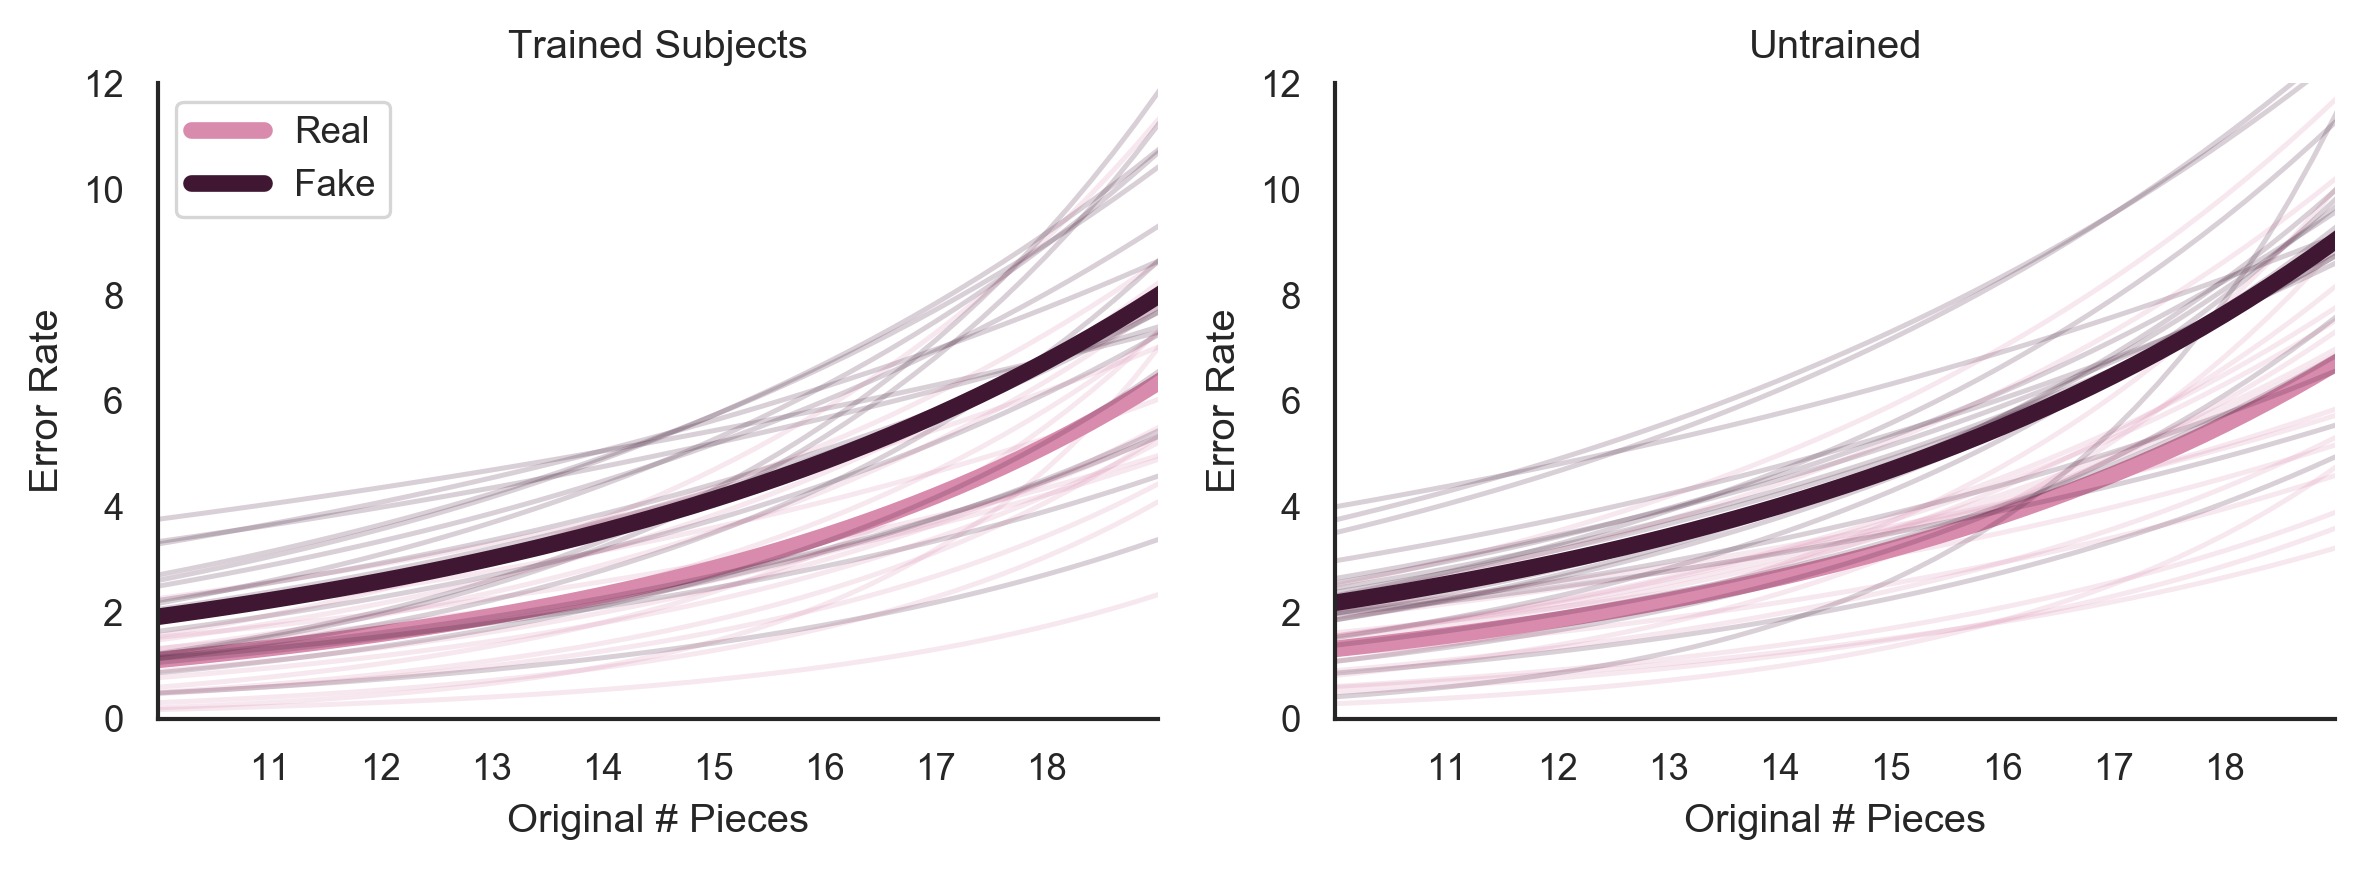

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

params_condition_filter = params['Condition'] == 'Trained'
params_position_filter = params['Is Real']

support = np.arange(0, 20, .2)

def get_fitted_lines(p):
    for i, row in enumerate(p.iterrows()):
        x = row[1]['x']
        b = row[1]['Intercept']
#         x = row[1]['x1']
#         b = 0
        
#         model = models_list[i][]
#         fit = model.predict(params=x, exog=support)
        fit = np.exp(x * support + b)
#         fit = 1 / (1 + np.exp(x * support))
#         fit = row[1]['prediction']
        
        yield fit        

# Trained 

ax = axes[0]

### Real

p = params.loc[params_condition_filter & params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors['real'], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors['real'], linewidth=4, label='Real')
    
### Fake

p = params.loc[params_condition_filter & ~params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors['fake'], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors['fake'], linewidth=4, label='Fake')


# Untrained 

ax = axes[1]

### Real

p = params.loc[~params_condition_filter & params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors['real'], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors['real'], linewidth=4)
    
### Fake

p = params.loc[~params_condition_filter & ~params_position_filter]
base = np.zeros_like(support)

for l in get_fitted_lines(p):
    ax.plot(support, l, color=colors['fake'], alpha=.2)
    base += l
    
mean = base / len(p)

ax.plot(support, mean, color=colors['fake'], linewidth=4)
    

    
sns.despine()

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Error Rate', xlabel='Original # Pieces', 
#     xlim=[9, 20], 
    ylim=[0, 12],
    xlim=[10, 19], 
#     ylim=[0, .6],
    xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
#     yticks=np.arange(9, 20, 1), yticklabels=np.arange(9, 20, 1)
)
plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()
plt.tight_layout()

In [36]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'MEAN CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        outputs.loc[idx, col] = g.apply(
            lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['y'].values)[0, 1]
        ).mean()

outputs

MEAN CORRCOEF,False,True
Trained,0.598326,0.549621
Untrained,0.663418,0.565286


In [37]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'SEM CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        corcoefs = g.apply(lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['y'].values)[0, 1])
        outputs.loc[idx, col] = corcoefs.std() / np.sqrt(len(corcoefs))
outputs

SEM CORRCOEF,False,True
Trained,0.0237662,0.0291216
Untrained,0.0260303,0.0268039


In [48]:
val = 'Intercept'

In [49]:
means = params.pivot_table(index='Condition', values=val, columns='Is Real', aggfunc=np.mean)
sems = params.pivot_table(index='Condition', values=val, columns='Is Real', aggfunc=lambda x: x.std() / np.sqrt(len(x)))

In [50]:
means.columns.name = 'MEANS'
means.index.name = None
means

MEANS,False,True
Trained,-1.138070,-2.244179
Untrained,-1.001364,-1.738867


In [51]:
sems.columns.name = 'SEMS'
sems.index.name = None
sems

SEMS,False,True
Trained,0.224586,0.325698
Untrained,0.253262,0.229450


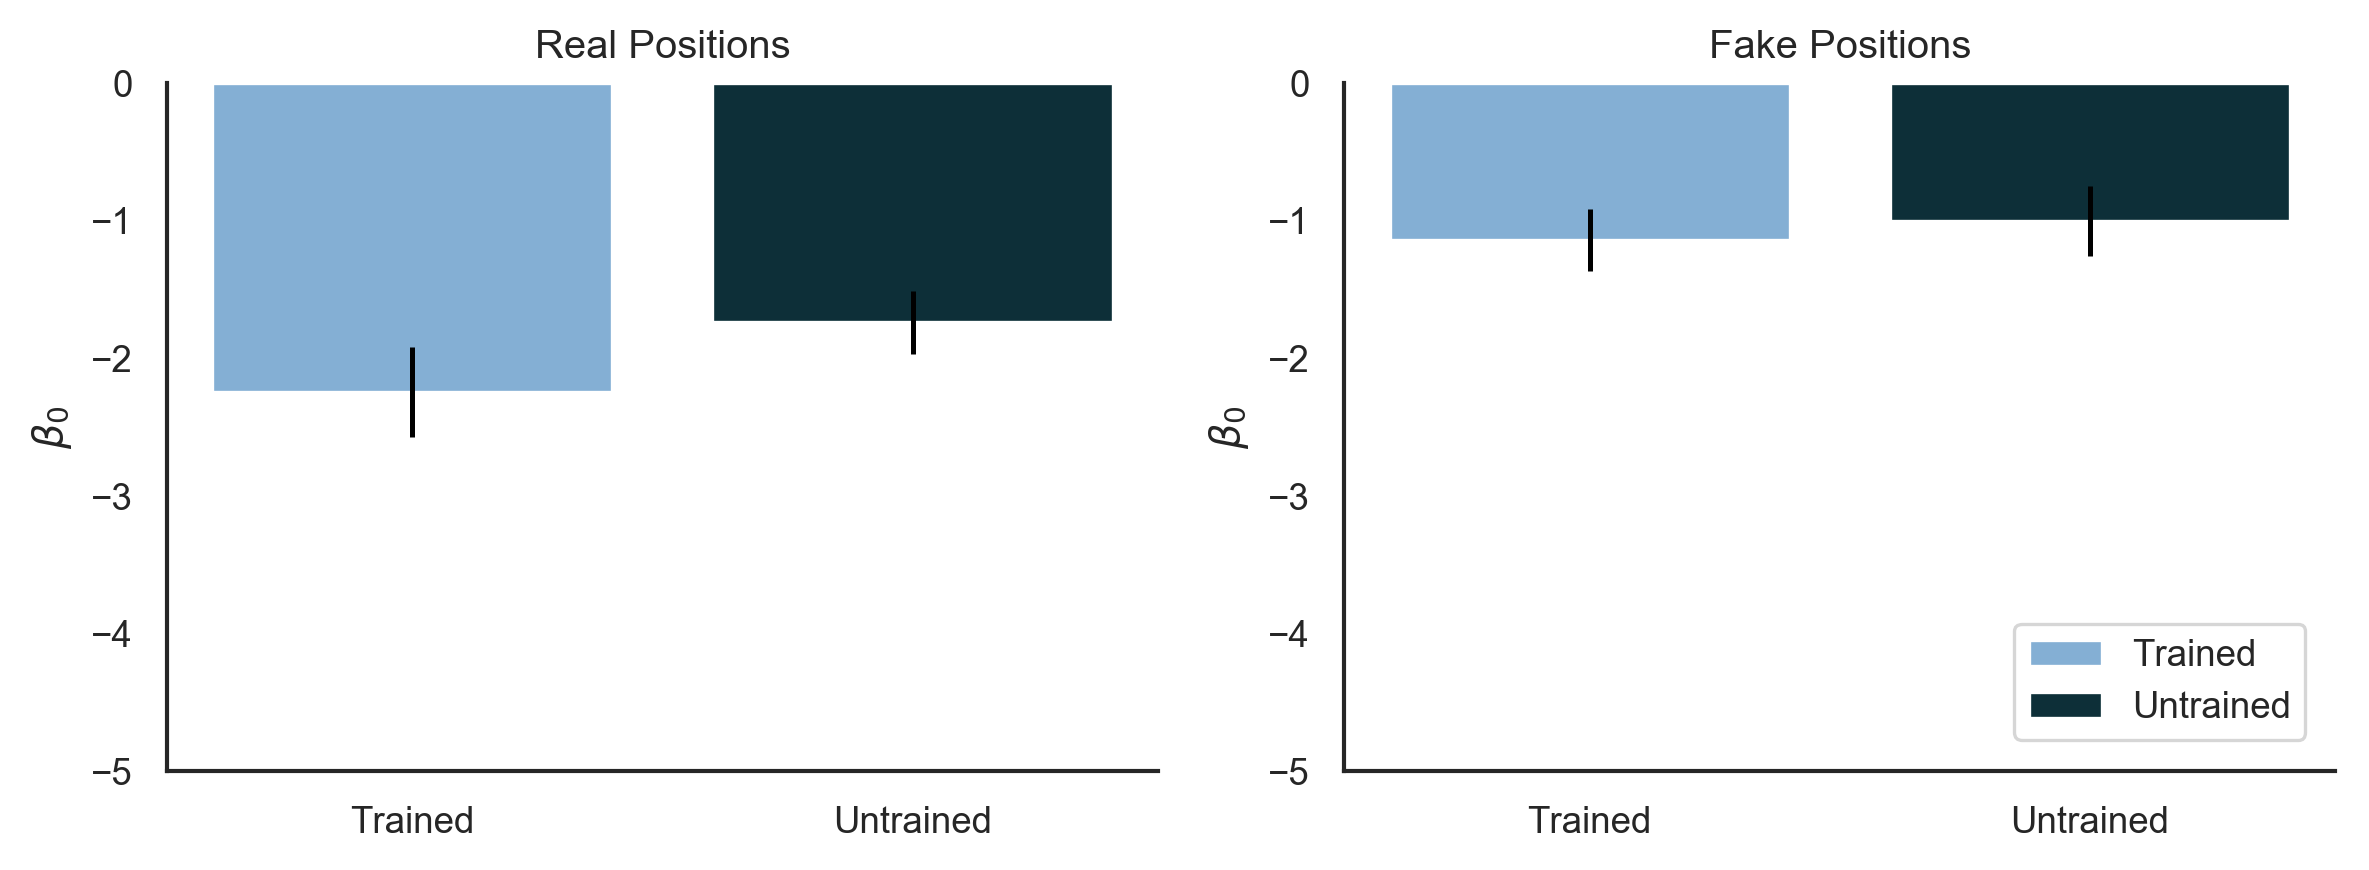

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

axes[0].bar([0], means.loc['Trained', True], color=colors['trained'], label='Trained')
axes[0].bar([1], means.loc['Untrained', True], color=colors['untrained'], label='Untrained')
axes[0].errorbar([0], means.loc['Trained', True], yerr=sems.loc['Trained', True], color='black')
axes[0].errorbar([1], means.loc['Untrained', True], yerr=sems.loc['Untrained', True], color='black')

axes[1].bar([0], means.loc['Trained', False], color=colors['trained'])
axes[1].bar([1], means.loc['Untrained', False], color=colors['untrained'])
axes[1].errorbar([0], means.loc['Trained', False], yerr=sems.loc['Trained', False], color='black')
axes[1].errorbar([1], means.loc['Untrained', False], yerr=sems.loc['Untrained', False], color='black')

plt.figlegend(loc=(.85, .15))

plt.setp(
    axes,
#     ylim=[0, .25], 
    ylim=[-5, 0],
    ylabel=r'$\mathit{\beta_0}$',
    xticks=[0, 1], xticklabels=['Trained', 'Untrained']
)

plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()
plt.tight_layout()

In [54]:
c = params['Condition'] == 'Trained'
r = params['Is Real'] == True

In [55]:
pvalues = params.pivot_table(
    index='Condition', values=val, columns='Is Real', 
    aggfunc=lambda x: sts.ttest_1samp(x, 0).pvalue
)

pvalues.columns.name = 'PVALUES'
pvalues.index.name = None
pvalues

PVALUES,False,True
Trained,0.000080,1.917837e-06
Untrained,0.000931,5.251977e-07


In [56]:
results = pd.DataFrame()

results.loc['Condition', 'True'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[~c & r, val].values).pvalue
results.loc['Condition', 'False'] = sts.ttest_ind(params.loc[c & ~r, val].values, params.loc[~c & ~r, val].values).pvalue

results.loc['Position Type', 'Trained'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[c & ~r, val].values).pvalue
results.loc['Position Type', 'Untrained'] = sts.ttest_ind(params.loc[~c & r, val].values, params.loc[~c & ~r, val].values).pvalue

In [57]:
results.columns.name = 'PVALUES\tConstant'
results.index.name = 'Variable'
results

PVALUES Constant,True,False,Trained,Untrained
Variable,,,,
Condition,0.212819,0.688705,NaN,NaN
Position Type,NaN,NaN,0.008252,0.037669
